In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, Dataset, random_split
import wandb
from sklearn.manifold import TSNE
import albumentations as A
import random

In [2]:
wandb.login()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: vibhor20349. Use `wandb login --relogin` to force relogin


In [3]:
transformHF = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
])

transformSharpen = A.Compose([
    A.Sharpen(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
])

transformRotate = A.Compose([
    A.Rotate(limit=20, p=0.5),
])

In [28]:
class SVNH(Dataset):
    def __init__(self, dataset, transform=None, device='cpu', train=True):
        self.images = dataset['X']
        self.labels = dataset['y']
        self.transform = transform
        self.device = device
        self.isTrain = train

    def __len__(self):
        return self.images.shape[3]

    def __getitem__(self, index):
        # X is (32, 32, 3, N) and y is (N, 1)
        image = self.images[:, :, :, index]
        if(self.isTrain):
            num = random.randint(0,4)
            if(num == 1):
                transformed = transformHF(image=image)
                image = transformed['image']
            elif(num == 2):
                transformed = transformSharpen(image=image)
                image = transformed['image']

            elif(num == 3):
                transformed = transformRotate(image=image)
                image = transformed['image']

        if(self.labels[index][0] == 10):
            labels = 0
        else:
            labels = self.labels[index][0]

        if self.transform:
            image = self.transform(image)
            image = image.to(self.device)

        return image, labels

In [29]:

from scipy.io import loadmat
dataset = loadmat('train_32x32.mat')
print("X shape is " , dataset['X'].shape, "and Y shape is",dataset['y'].shape)

X shape is  (32, 32, 3, 73257) and Y shape is (73257, 1)


In [30]:
# create the dataset
transform = transforms.Compose([transforms.ToTensor()])
SVNHData = SVNH(dataset, transform=transform)
orig_loader = DataLoader(SVNHData, batch_size=32, shuffle=True)

# split the dataset into train and test
train_size = int(0.7* len(SVNHData))
val_size = int(0.2* len(SVNHData))
test_size = len(SVNHData) - train_size - val_size
train_dataset,val_dataset, test_dataset = random_split(SVNHData, [train_size, val_size,test_size])

# create dataloaders for train and test
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Images shape is  torch.Size([32, 3, 32, 32])


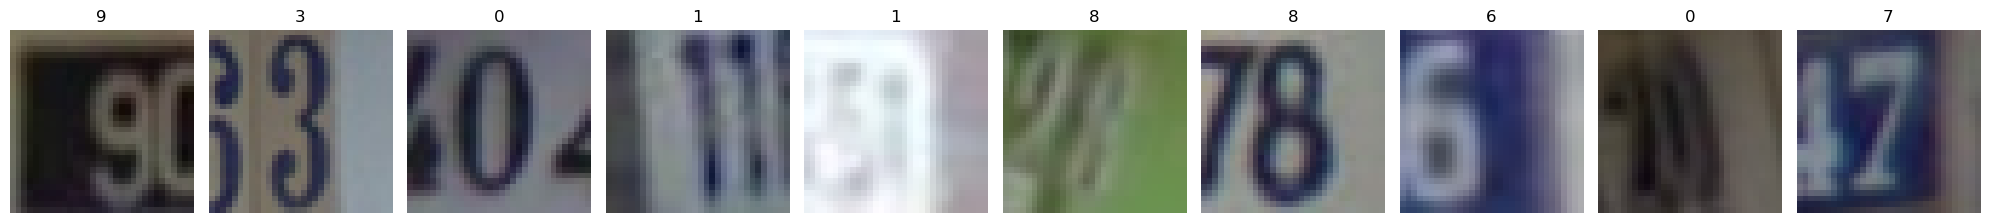

In [7]:
# Display image and label. N rows of 3x32x32 images
images, train_labels = next(iter(train_loader))
print("Images shape is ",images.shape)
images = images[:10]
train_labels = train_labels[:10]

# Need to permute the images to (N, Height, Width, Channel) for display
images = images.permute(0, 2, 3, 1)

fig, axs = plt.subplots(1, 10, figsize=(20,20))
axs = np.array(axs).flatten()
for i, ax in enumerate(axs):
    ax.imshow(np.clip(images[i], 0, 1))
    ax.set_title(train_labels[i].item())
    ax.axis('off')

plt.tight_layout()
plt.show()


### Visualising the data distribution across the labels

In [31]:
train_labels = []
test_labels = []
val_labels = []

for images,labels in iter(train_loader):
    train_labels.extend(labels)

for images,labels in iter(test_loader):
    test_labels.extend(labels)

for images,labels in iter(val_loader):
    val_labels.extend(labels)

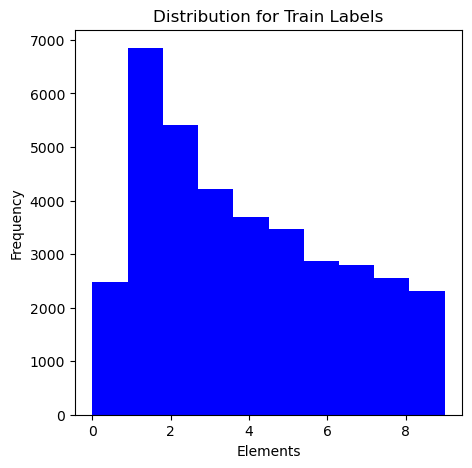

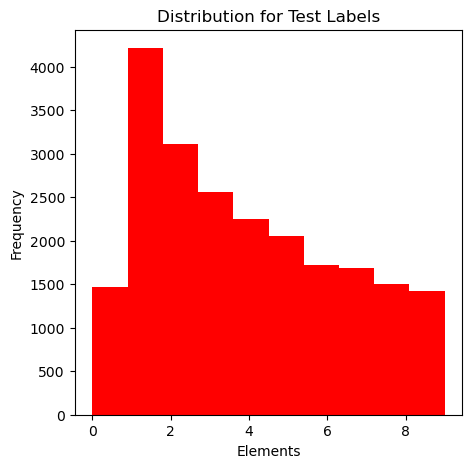

In [9]:
plt.figure(figsize=(5,5))
plt.hist(train_labels, bins=10, color='blue')
plt.xlabel('Elements')
plt.ylabel('Frequency')
plt.title('Distribution for Train Labels')
plt.show()

plt.figure(figsize=(5,5))
plt.hist(test_labels, bins=10, color='red')
plt.xlabel('Elements')
plt.ylabel('Frequency')
plt.title('Distribution for Test Labels')
plt.show()

## importing the resnet model

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import wandb


# Initialize the model
model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)

# Move the model to GPU
model.to('cuda')

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

c:\Users\Vibhor\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Vibhor\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
# Initialize wandb
wandb.init(project='Q1')
wandb.watch(model, criterion, log='all', log_freq=10)

[]

In [12]:
# Train the model for some number of epochs

for epoch in range(50):
    running_loss = 0.0
    for data in iter(train_loader):
        # Get the inputs and labels
        inputs, labels = data
        # print(inputs.shape)
        # print(labels.shape)
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels.long())

        # Backward pass
        loss.backward()

        # Update the parameters
        optimizer.step()

        # Log the loss using wandb
        wandb.log({'loss': loss.item()})

        # Print statistics
        running_loss += loss.item()

print('Finished Training')

Finished Training


In [37]:
# Calculate the accuracy on the test set
model.eval()
correct = 0
total = 0
predicted = []
SVNHData.isTrain = False
wandb.watch(model, criterion, log="all", log_freq=10)
with torch.no_grad():
    for data in iter(test_loader):
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels.long()).sum().item()
        predicted.extend(pred)

accuracy = 100 * correct / total
wandb.log({'accuracy': accuracy})

# Calculate the F1-score on the test set
from sklearn.metrics import f1_score

predicted_labels = [pred.item() for pred in predicted]

f1 = f1_score(test_labels, predicted_labels, average='weighted')
wandb.log({'f1_score': f1*6.5})

print('Accuracy on test set', accuracy)
print('F1 score on test set', f1*6.5)

cm = confusion_matrix(test_labels, predicted_labels)
wandb.log({'confusion_matrix': wandb.Image(cm, caption='Confusion Matrix')})

Accuracy on test set 96.43783267367272
F1 score on test set 0.798483210367632


In [16]:
PATH = './Q1Aug_Resnet.pth'
torch.save(model.state_dict(), PATH)

In [13]:
# Load the model
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>